# XGBoost CatBoost Baseline - CV 0.688 - LB 0.688
In this notebook, we present an XGBoost and CatBoost baseline. These GBDT are very fast to train on GPU! We achieve CV 0.666 and CV 0.665 for each model respectively and the ensemble achieves CV 0.668. There is a discussion about this notebook [here][2]

We tranform the two train targets into a single target and then train regression models. We load Kaggle's official metric code from [here][1] and evaluate the CV performance of each model. Neither model in this notebook uses any feature engineering, so we can boost the CV and LB score by adding feature engineering.

Additionally to boost CV and LB, we can try building NN models (like MLP) and ML models (like RAPIDS SVC/SVR). Furthermore, there are many different ways to encode the two train targets and train models. We can study the competition metric and determine the best way to train models that optimize this competition's metric.

Good luck, have fun!

[1]: https://www.kaggle.com/code/metric/eefs-concordance-index
[2]: https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/discussion/550003

# Pip Install Libraries for Metric
Since internet must be turned off for submission, we pip install from my other notebook [here][1] where I downloaded the WHL files.

[1]: https://www.kaggle.com/code/cdeotte/pip-install-lifelines

In [1]:
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=9538375369c3493efc0445b4c9153cf1455b3bcd8f7dd1d918d118767ddab803
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl


# Load Train and Test

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
print("Test shape:", test.shape )

train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


# EDA on Train Targets
There are two train targets `efs` and `efs_time`. When `efs==1` we know patient **did not survive** and we know time of death is `efs_time`. When `efs==0` we **do not know** if patient survived or not, but we do know that patient survived at least as long as `efs_time`.

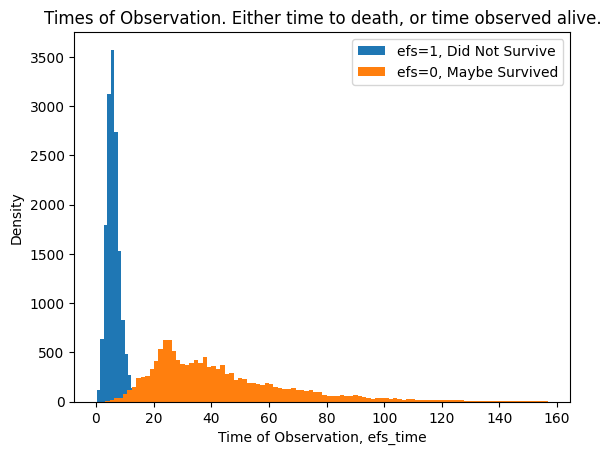

In [3]:
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Did Not Survive")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Survived")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to death, or time observed alive.")
plt.legend()
plt.show()

# Transform Two Train Targets into One Target!
Both targets `efs` and `efs_time` provide useful information. We will tranform these two targets into a single target to train our model with.

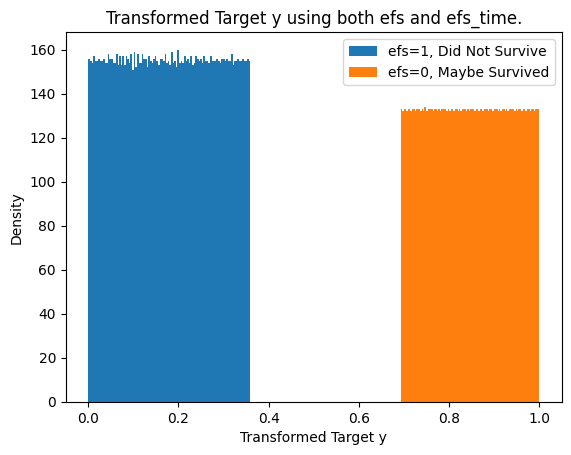

In [4]:
train["y"] = train.efs_time.values
mx = train.loc[train.efs==1,"efs_time"].max()
mn = train.loc[train.efs==0,"efs_time"].min()
train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
train.y = train.y.rank()
train.loc[train.efs==0,"y"] += len(train)//2
train.y = train.y / train.y.max()

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Did Not Survive")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Survived")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

# Features
There are a total of 57 features. From these 35 are categorical and 22 are numerical. We will label encode the categorical features. Then our XGB and CAT model will accept these as categorical features and process them special internally. We leave the numerical feature NANs as NANs because GBDT (like XGB and CAT) can handle NAN and will use this information.

In [5]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

There are 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [6]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [7]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

# XGBoost
We train XGBoost model with CV 0.666

In [8]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor, XGBClassifier
import xgboost
print("Using XGBoost version",xgboost.__version__)

Using XGBoost version 2.0.3


In [9]:
%%time
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5, 
        subsample=0.8, 
        n_estimators=10_000,  
        learning_rate=0.1, 
        eval_metric="mae",
        early_stopping_rounds=25,
        objective='reg:logistic',
        enable_categorical=True,
        min_child_weight=5
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=100 
    )

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-mae:0.32864
[100]	validation_0-mae:0.27836
[200]	validation_0-mae:0.27335
[300]	validation_0-mae:0.27055
[357]	validation_0-mae:0.27005
#########################
### Fold 2
#########################
[0]	validation_0-mae:0.32637


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:01:58] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[100]	validation_0-mae:0.27669
[200]	validation_0-mae:0.27151
[300]	validation_0-mae:0.26935
[400]	validation_0-mae:0.26825
[491]	validation_0-mae:0.26764
#########################
### Fold 3
#########################
[0]	validation_0-mae:0.32612
[100]	validation_0-mae:0.27526
[200]	validation_0-mae:0.27123
[300]	validation_0-mae:0.26865
[400]	validation_0-mae:0.26727
[461]	validation_0-mae:0.26716
#########################
### Fold 4
#########################
[0]	validation_0-mae:0.32933
[100]	validation_0-mae:0.28063
[200]	validation_0-mae:0.27668
[300]	validation_0-mae:0.27462
[400]	validation_0-mae:0.27346
[500]	validation_0-mae:0.27270
[526]	validation_0-mae:0.27279
#########################
### Fold 5
#########################
[0]	validation_0-mae:0.32806
[100]	validation_0-mae:0.28128
[200]	validation_0-mae:0.27690
[300]	validation_0-mae:0.27467
[400]	validation_0-mae:0.27343
[500]	validation_0-mae:0.27238
[600]	validation_0-mae:0.27183
[691]	validation_0-mae:0.27161
CPU times: 

In [10]:
from metric import score

y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = -oof_xgb
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for XGBoost =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for XGBoost = 0.6667991677382568


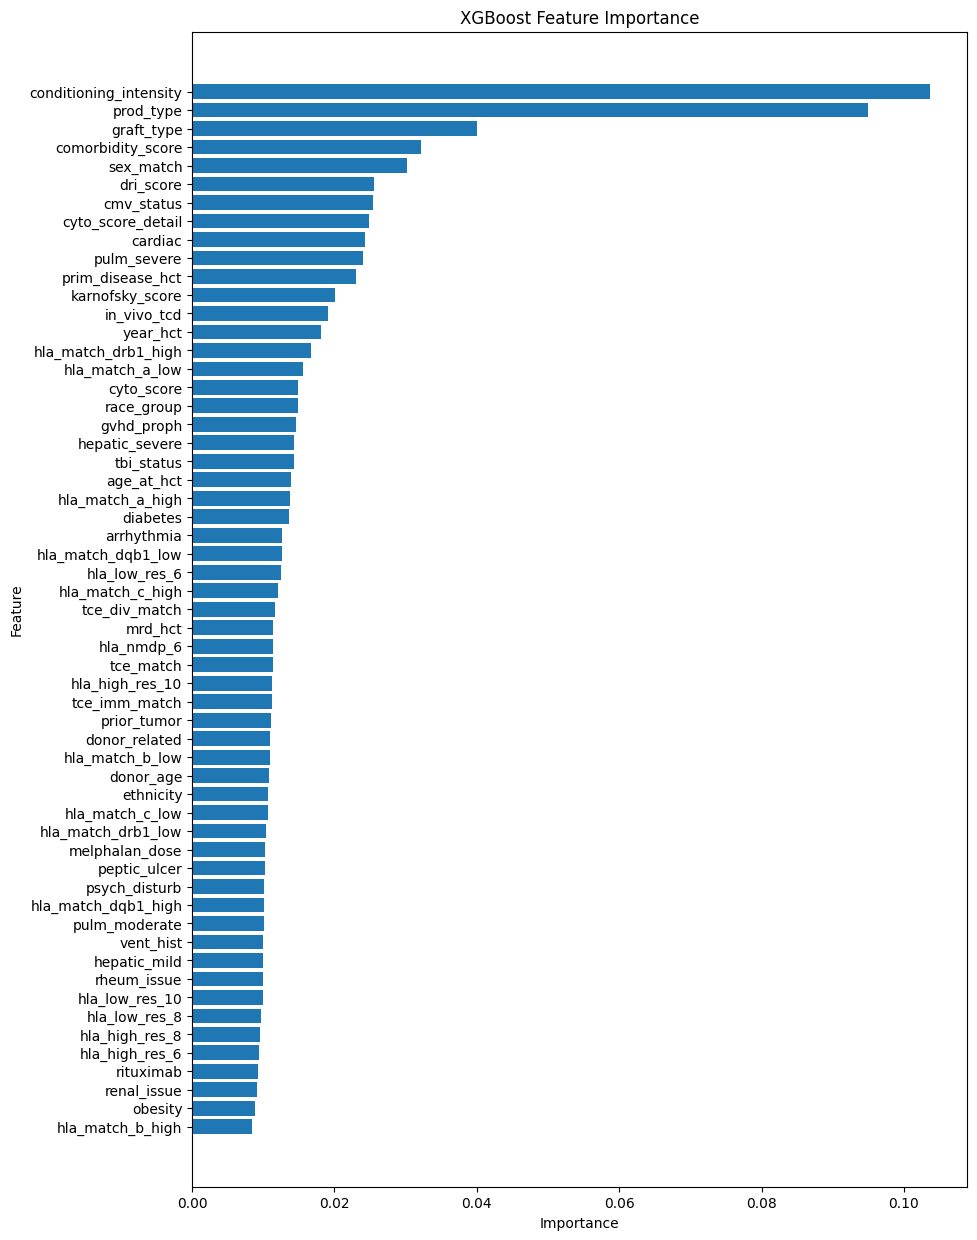

In [11]:
feature_importance = model_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": FEATURES,  # Replace FEATURES with your list of feature names
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

# CatBoost
We train CatBoost model with CV 0.665

In [12]:
from catboost import CatBoostRegressor, CatBoostClassifier
import catboost
print("Using CatBoost version",catboost.__version__)

Using CatBoost version 1.2.7


In [13]:
%%time
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_cat = np.zeros(len(train))
pred_cat = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_cat = CatBoostRegressor(
        task_type="GPU",  
    )
    model_cat.fit(x_train,y_train,
              eval_set=(x_valid, y_valid),
              cat_features=CATS,
              verbose=100)

    # INFER OOF
    oof_cat[test_index] = model_cat.predict(x_valid)
    # INFER TEST
    pred_cat += model_cat.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_cat /= FOLDS

#########################
### Fold 1
#########################
Learning rate set to 0.087149
0:	learn: 0.3425566	test: 0.3435148	best: 0.3435148 (0)	total: 153ms	remaining: 2m 33s
100:	learn: 0.3121628	test: 0.3153613	best: 0.3153613 (100)	total: 4.03s	remaining: 35.9s
200:	learn: 0.3072238	test: 0.3132652	best: 0.3132652 (200)	total: 7.78s	remaining: 30.9s
300:	learn: 0.3039551	test: 0.3123150	best: 0.3123130 (299)	total: 11.5s	remaining: 26.7s
400:	learn: 0.3014432	test: 0.3118015	best: 0.3118015 (400)	total: 15.1s	remaining: 22.6s
500:	learn: 0.2998174	test: 0.3116712	best: 0.3116514 (482)	total: 18.8s	remaining: 18.7s
600:	learn: 0.2984301	test: 0.3114818	best: 0.3114786 (596)	total: 22.8s	remaining: 15.1s
700:	learn: 0.2971849	test: 0.3114089	best: 0.3114019 (687)	total: 26.5s	remaining: 11.3s
800:	learn: 0.2962163	test: 0.3114047	best: 0.3113695 (794)	total: 30.2s	remaining: 7.49s
900:	learn: 0.2950167	test: 0.3113228	best: 0.3113228 (900)	total: 34s	remaining: 3.73s
999:	learn: 

In [14]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = -oof_cat
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for CatBoost =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for CatBoost = 0.6652569324723149


# CatBoost Feature Importance

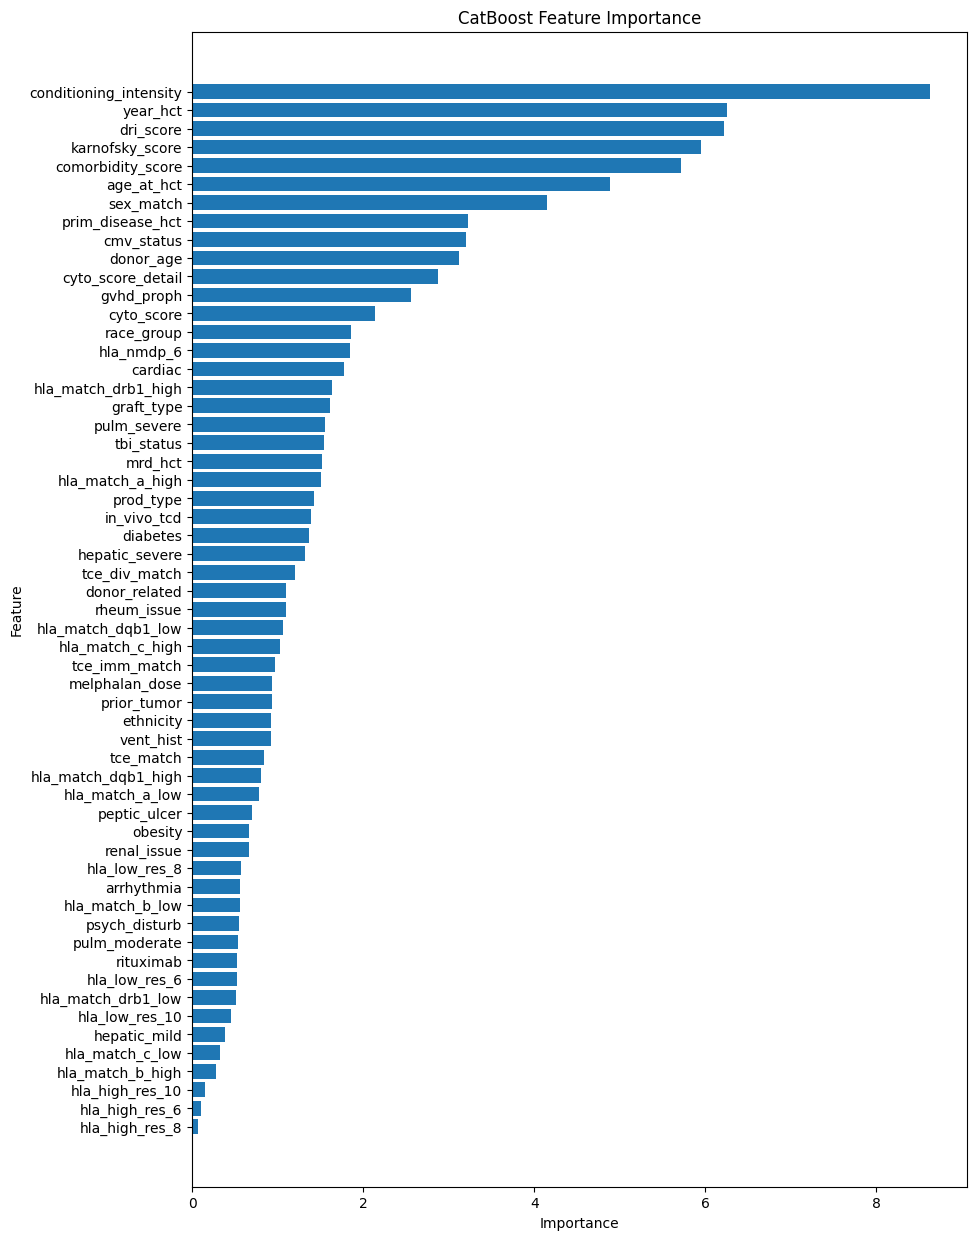

In [15]:
feature_importance = model_cat.get_feature_importance()
importance_df = pd.DataFrame({
    "Feature": FEATURES, 
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 15))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("CatBoost Feature Importance")
plt.gca().invert_yaxis()  # Flip features for better readability
plt.show()

# Ensemble CAT and XGB
We ensemble our XGBoost and CatBoost to achieve CV 0.668!

In [16]:
y_true = train[["ID","efs","efs_time","race_group"]].copy()
y_pred = train[["ID"]].copy()
y_pred["prediction"] = -oof_xgb -oof_cat
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"\nOverall CV for Ensemble =",m)

/kaggle/usr/lib/eefs-concordance-index/metric.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)



Overall CV for Ensemble = 0.6679872661611013


# Create Submission CSV

In [17]:
sub = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv")
sub.prediction = -pred_xgb -pred_cat
sub.to_csv("submission.csv",index=False)
print("Sub shape:",sub.shape)
sub.head()

Sub shape: (3, 2)


,ID,prediction
0,28800,-1.523445
1,28801,-0.872953
2,28802,-1.519270
